# Algorithmic Analysis of Musical Texture 
# Samuel Silverstein 
## CS4490

In [202]:
#make imports 
import string
import pandas as pd
import numpy as np 
import csv
from music21 import *
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import cm
from sklearn import preprocessing
from sklearn.decomposition import PCA
from scipy.spatial import distance_matrix
from scipy.ndimage.filters import gaussian_filter
import networkx as nx

# PART A: 
## Create parser object and flatten mxl file

In [193]:
#load in parts of a music piece 
name = converter.parse('Tallis40.mxl')
flat_stream = name.parts.flat.getElementsByClass(note.Note)

#Find number of measures in piece
num_measures = []
for curr_note in name.parts.flat.getElementsByClass(note.Note):
    if curr_note.measureNumber not in num_measures:
        num_measures.append(curr_note.measureNumber)
    else:
        pass
num_measures = np.array(num_measures)

min_measure = np.amin(num_measures)
max_measure = np.amax(num_measures)
print("Measure Bounds is: (", min_measure, ",", max_measure, ")")



#Assign each part a unique identifier 
part_names = []
part_id = 1
for curr_part in name.recurse().parts:
    
    curr_part.partNumber = part_id
    part_names.append(curr_part.id)
    part_id += 1;

part_names = np.array(part_names)


##create NxM matrix where n is number of parts, and each part has m measures 
all_parts = []
all_measures = []
for curr_part in name.recurse().parts:
    part_notes = []
    note_measure = []
    for curr_note in curr_part.flat.getElementsByClass(note.NotRest):
        if(curr_note.isNote):
            part_notes.append(curr_note)
            note_measure.append(curr_note.measureNumber)
        #else: #then it is a chord, so take its root for now
           # part_notes.append(curr_note.fifth)
            #note_measure.append(curr_note.measureNumber)
    all_parts.append(part_notes)
    all_measures.append(note_measure) 
all_parts = np.array(all_parts, dtype=object)
all_measures = np.array(all_measures, dtype=object)



#Create dictionary object where key is the part name, 
note_dict = dict(zip(part_names, all_parts)) 
measure_dict = dict(zip(part_names, all_measures))



#Recurse throuch each part, and append each rest object to the part array
all_part_rest = []
for curr_part in name.recurse().parts:
    part_rests = []
    for curr_rest in curr_part.flat.getElementsByClass(note.Rest):
        part_rests.append(curr_rest)
    all_part_rest.append(part_rests)

#Make dict object for all rest object for each part
rest_dict = dict(zip(part_names, all_part_rest))


Measure Bounds is: ( 2 , 139 )


## Functions which takes any part ID, and stores all relevant information inside a DataFrame (depending on if it is a a rest_df, or note_df)

In [194]:
def part_to_note_df(part_name):
    part_pitch = []
    part_midi = []
    part_offset = []
    part_measure = []
    part_beat_dur = []
    part_beat_str = []
    part_names = []
    for curr_note in note_dict.get(part_name):
        part_pitch.append(curr_note.pitch)
        part_offset.append(curr_note.offset)
        part_midi.append(curr_note.pitch.midi)
        part_beat_dur.append(curr_note.duration.quarterLength)
        part_beat_str.append(curr_note.beatStrength)
        part_names.append(part_name)
    for curr_note in measure_dict.get(part_name):
        part_measure.append(curr_note)
    #concatenate columns into dataframe object 
    note_df = pd.DataFrame({'Part_Name': part_names, 'Note_Pitch': np.array(part_pitch), 'Note_MIDI': np.array(part_midi), 'Quarter_Length': np.array(part_beat_dur), 'Beat_Strength':np.array(part_beat_str), 'Note_Offset': np.array(part_offset), 'Note_Measure': np.array(part_measure)})
    return note_df
 
#a function which takes stores rest information for each part in a dataframe
def part_to_rest_df(part_name):
    part_offset = []
    part_duration = []
    part_measure = []
    for curr_rest in rest_dict.get(part_name):
        part_offset.append(curr_rest.offset)
        part_duration.append(curr_rest.duration.quarterLength) #DOES THIS CONSIDER THE TIME SIGNATURE ALREADY?
        part_measure.append(curr_rest.measureNumber)
    #concatenate columns into dataframe object for parts rests 
    rest_df = pd.DataFrame({'Rest_Duration': np.array(part_duration), 'Rest_Offset': np.array(part_offset), 'Rest_Measure':np.array(part_measure)})
    return rest_df

In [195]:
#load all dataframes into dictionary object (different dicts for notes and rests)
temp_note_dfs = []
temp_rest_dfs = []
lrg_offset = -1
sml_offset = 10000
for prt in part_names:
    temp_note = part_to_note_df(prt)
    temp_note_dfs.append(temp_note)
    temp_rest = part_to_rest_df(prt)
    temp_rest_dfs.append(temp_rest)
    #get smallest and largest global offset 
    if np.amin(temp_note.Note_Offset) < sml_offset:
        sml_offset = np.amin(temp_note.Note_Offset)
    if np.amax(temp_note.Note_Offset) > lrg_offset:
        lrg_offset = np.amax(temp_note.Note_Offset)
    
print(sml_offset)
note_dictionary = dict(zip(part_names, temp_note_dfs))
rest_dictionary = dict(zip(part_names, temp_rest_dfs))

print(part_names)

rest_dictionary.get('Guitar')


1.0
['S1' 'S2' 'S3' 'S4' 'S5' 'S6' 'S7' 'S8' 'A1' 'A2' 'A3' 'A4' 'A5' 'A6'
 'A7' 'A8' 'T1' 'R1' 'T2' 'R2' 'T3' 'R3' 'T4' 'R4' 'T5' 'R5' 'T6' 'R6'
 'T7' 'R7' 'T8' 'R8' 'B1' 'B2' 'B3' 'B4' 'B5' 'B6' 'B7' 'B8']


In [196]:
#A function that takes a part name, and slices all rows corresponding to the notes specified measure range
def note_slice(part_name, m_range):
    n_df = note_dictionary.get(part_name)
    n_measure = n_df[(n_df["Note_Measure"] >= m_range[0]) & (n_df["Note_Measure"] <= m_range[1])]
    n_mod = (n_measure.Note_Offset) % 4 #RIGHT NOW IS -1 TO HANDLE THE SHIFT WITH THE TIME SIGNATURE (TALK TO DR DE SOUZA)
    n_measure = n_measure.assign(note_mod_offset = n_mod)
    return n_measure #also return r_measure

#A function which takes a part name and slices all rows corresponding to the rests in the specified measure range
def rest_slice(part_name, m_range):
    r_df = rest_dictionary.get(part_name)
    r_measure = r_df[(r_df["Rest_Measure"] >= m_range[0]) & (r_df["Rest_Measure"] <= m_range[1])]
    r_mod = (r_measure.Rest_Offset) % 4
    r_measure = r_measure.assign(rest_mod_offset = r_mod)
    return r_measure
    
test1 = note_slice("Piano", (1,10))
test1
#test2 = rest_slice("Piano", (1,10))
#test2



TypeError: 'NoneType' object is not subscriptable

### Functions taken from Calvin comod_v1.py

In [189]:
# ~~~ Finding Average Pitches ~~~ #

def averagePitchFinder(pairList,time,window):               # function for finding the average pitch during the window. Takes into account lengths of notes, and weighes them proportionally. returns the average pitch value as a 'midi' number, though it will likely be a fraction
    listOfPitches = []                                      # running list of all pitches in this window, organized as pairs in the form [midi pitch, duration as a fraction of the window]
    
    for pair in pairList:
        
        if pair[0] <= time and pair[2] >= time - pair[0] + window:                                  # option 1, notes that attack before or at the window and sustain throughout the entire window
            return float(pair[1])
        
        if pair[0] <= time and pair[2] > time - pair[0] and pair[2] < time - pair[0] + window:     # option 2, notes that attack before or at the window and end before the end of the window
            usableLength = pair[2] - (time - pair[0])                                                   # the amount of time the note spends inside the window
            proportion = usableLength/window                                                            # fraction for how much of the window this note occupies
            listOfPitches.append([pair[1],proportion])
            
        if pair[0] > time and pair[0] < time + window:                                              # option 3, notes that begin in the middle of the window
            if pair[2] > window - (pair[0] - time):
                usableLength = window - (pair[0] - time)                                            # usable length is truncated if the note continues past the window
            else:
                usableLength = pair[2]
            proportion = usableLength/window
            listOfPitches.append([pair[1],proportion])
    
    leastProportion = 2
    totalProportions = 0
    for x in listOfPitches:
        if x[1] < leastProportion:
            leastProportion = x[1]
    
    ratioScale = 1/leastProportion      
    for x in listOfPitches:
        x[1] = x[1] * ratioScale
        totalProportions = totalProportions + x[1]
    
    averagePitch = 0
    for x in listOfPitches:
        averagePitch = averagePitch + x[0] * x[1]
    
    try:
        return averagePitch / totalProportions
    except:
        return('None')



# ~~~ calculating comodulation 2.0 ~~~ #


def comodulate(c1,c2):                                 # c1 and c2 represent 'contour 1' and 'contour 2', as the comodulation function inputs contours rather than notes
    try:                                                # check if both arguments are real contours, and not placeholders. note that no value is explicitely returned for these; they dont contribute to the total comod score
        if c1 * c2 <= 0:                                # check for contrary and oblique motion
            if c1 == c2 == 0:                           # check for both notes sustaining
                return 1.0                              # returns 1 when notes sustain together
            else:
                return 0.0                              # returns 0 for contrary/oblique motion
        else:
            return 1.0
    except:
        pass




In [197]:


#make empty matrix which will hold all synchronous percentages between parts 
sync_mat = np.zeros((len(part_names), len(part_names)))

for i in range(part_names.shape[0]):
    for j in range(part_names.shape[0]):
        p_denom = np.array(note_slice(part_names[i], (1,100)).Note_Offset)
        p_numer = np.array(note_slice(part_names[j], (1,100)).Note_Offset)
        share_offset = np.intersect1d(p_denom, p_numer).shape[0]
        if p_denom.shape[0] == 0:
            pass
        else:
            avg_sync = share_offset / p_denom.shape[0]
            sync_mat[i][j] = avg_sync
        
sync_mat.shape

#make empty matrix which will hold all asynchronous percentages between parts 
async_mat = np.zeros((len(part_names), len(part_names)))
for i in range(part_names.shape[0]):
    #slice notes first so we see where notes begin, so we can slice rests after the part is introduced in the piece 
    start = note_slice(part_names[i], (1,100)).Note_Measure.to_numpy()[0]
    for j in range(part_names.shape[0]):
        n_denom = np.array(note_slice(part_names[i], (1,100)).Note_Offset)
        r_numer = np.array(rest_slice(part_names[j], (start, 100)).Rest_Offset)
        share_offset = np.intersect1d(n_denom, r_numer).shape[0]
        if n_denom.shape[0] == 0:
            pass
        else:
            if part_names[i] == part_names[j]:
                async_mat[i][j] = 1
            else:
                avg_async = share_offset/n_denom.shape[0]
                async_mat[i][j] = avg_async


                
#calvins code is below                 
                
                
#calculate pitch averages as window slides across, and store in an array for each part
avg_pitch = []
for i in range(part_names.shape[0]):
    window_strt_loc = sml_offset
    window = 5
    pt_avg = []
    offs = np.array(note_slice(part_names[i], (1,100)).Note_Offset)
    midi = np.array(note_slice(part_names[i], (1,100)).Note_MIDI)
    q_len = np.array(note_slice(part_names[i], (1,100)).Quarter_Length)
    triplet = np.stack((offs, midi, q_len), axis=1)
    while window_strt_loc <= lrg_offset:
        pt_avg.append(averagePitchFinder(triplet, window_strt_loc, window))
        window_strt_loc = window_strt_loc + window
    avg_pitch.append(pt_avg)
    
#calculate contours for each part
contours = []
for row in avg_pitch:
    thisRowsContours = []         # new list for each row
    counter = 0                                 # counter resets for the next part
    while counter < len(row) - 1:
        try:
            thisRowsContours.append(row[counter+1]-row[counter])    # takes the difference between the note at the window the counter is pointing to, and the next window
        except:
            thisRowsContours.append('None')      # placeholder if the key pitch is the 'None' string from before
        counter = counter + 1                   # moves to the next counter
    contours.append(thisRowsContours)
    
    

#calculate pitch comodulation between all parts, resulting in mxm matrix, where m is number of parts
comod_mat = []                                           # array for all the comodulation scores. easy to store and put into a csv
uniqueComods = []

for thisPart in range(part_names.shape[0]):                       # first part to check by, and creates a list of this part comodulated against every other part. That list is a row in the final 'arrayOfComod'
    thisPartsComod = []                          # begins the list with the part name, useful for the csv file
    row1 = contours[thisPart]         # row from the contour array for thisPart
        
    for otherPart in range(part_names.shape[0]):                  # part to compare against
        row2 = contours[otherPart]    # row from the contour array for otherPart
        subScores = []                                      # list keeps track of the 'running scores' so far for this pair of parts, until all the countours have been compared
        counter = len(row1)                                 # counts down for each element in the rows. Has to be a counter to keep the rows lined up; 'for' statements wont work
            
        while counter > 0:
            if thisPart == otherPart:
                subScores.append(1.0)
            else:
                subScores.append(comodulate(row1[counter-1],row2[counter-1]))       # uses the 'comoduate' function (made above) to gather a score for each syncronous contour
            counter = counter - 1
            
        subScores = [x for x in subScores if type(x) is float]                      # 'cleans' this list to only contain numbers
        try:
            thisPartsComod.append(sum(subScores)/len(subScores))                    # appends the average of the subscores, to create a total score for this pair of parts
            if thisPart < otherPart:
                uniqueComods.append(sum(subScores)/len(subScores))                  # collects the unique
        except:
            thisPartsComod.append(0.0)                                              # if an error occurs (it would be a div/0 error, then the pair of parts' comod score must be 0
            if thisPart < otherPart:
                uniqueComods.append(0.0)                
                
            
        
    comod_mat.append(thisPartsComod)                                             # after thisPart has been compared against all the parts, the finished row is added to the array

comod_mat = np.array(comod_mat)


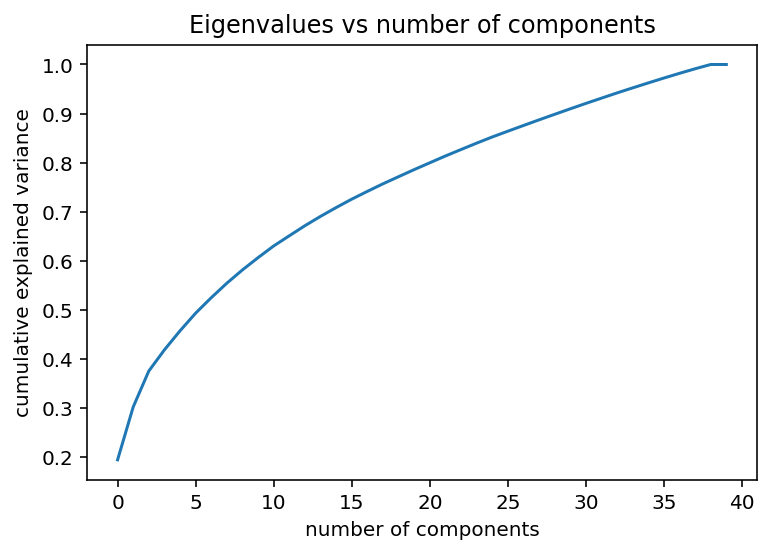

In [198]:
data = pd.concat([pd.DataFrame(sync_mat), pd.DataFrame(async_mat), pd.DataFrame(comod_mat)], axis=1)
norm_data = pd.DataFrame(preprocessing.normalize(data), columns=data.columns)
gen_pca = PCA()
gen_pca.fit(norm_data)
plt.plot(np.cumsum(gen_pca.explained_variance_ratio_))
plt.title("Eigenvalues vs number of components")
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

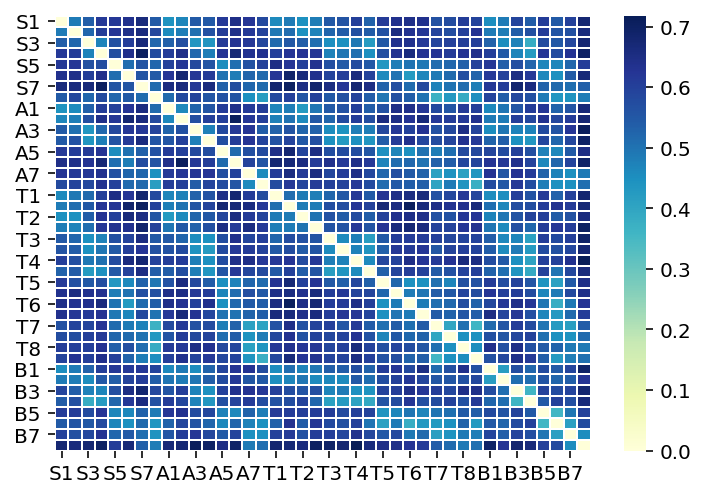

In [219]:
pca8 = PCA(n_components=35)

X_pca8 = pca8.fit_transform(norm_data)

#df = pd.DataFrame(X_pca8)



df = pd.DataFrame(X_pca8,  index = part_names)
dist = pd.DataFrame(distance_matrix(df.values, df.values), index=df.index, columns=df.index)
dist

ax = sns.heatmap(dist, linewidth=0.5,cmap="YlGnBu")

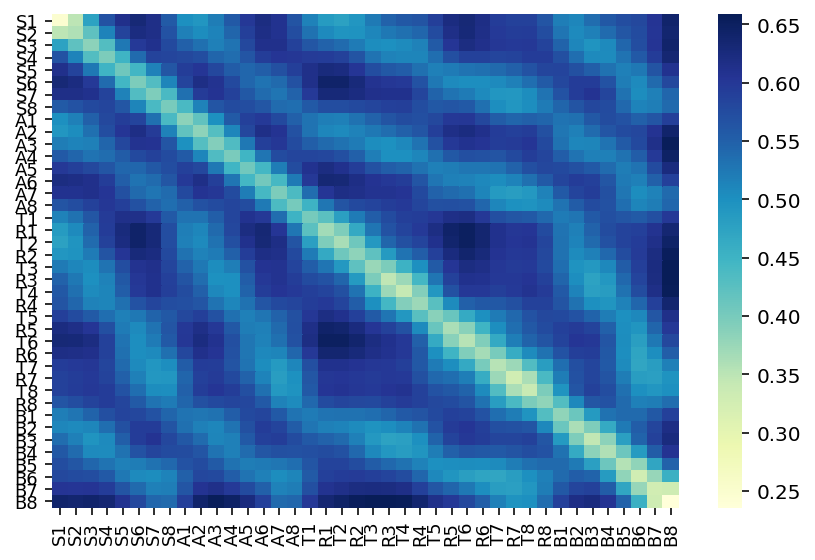

In [220]:
df3_smooth = gaussian_filter(dist, sigma=1)
ax = sns.heatmap(df3_smooth, yticklabels=part_names, xticklabels=part_names,cmap="YlGnBu") 
ax.set_xticklabels(ax.get_xticklabels(), fontsize=9)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=9)
plt.tight_layout()
plt.show()

In [ ]:
ax = sns.countplot(x="Column", data=ds)

ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)
plt.tight_layout()
plt.show()